This package implements the basic machinery for decorrelated backpropagation.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
import matplotlib.pyplot as plt

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

We start by showing effective decorrelation of correlated input

iteration 0; average off-diagonal covariance: 0.206684
iteration 1; average off-diagonal covariance: 0.204732
iteration 2; average off-diagonal covariance: 0.202813
iteration 3; average off-diagonal covariance: 0.200928
iteration 4; average off-diagonal covariance: 0.199076
iteration 5; average off-diagonal covariance: 0.197255
iteration 6; average off-diagonal covariance: 0.195465
iteration 7; average off-diagonal covariance: 0.193705
iteration 8; average off-diagonal covariance: 0.191974
iteration 9; average off-diagonal covariance: 0.190272
iteration 10; average off-diagonal covariance: 0.188597
iteration 11; average off-diagonal covariance: 0.186950
iteration 12; average off-diagonal covariance: 0.185329
iteration 13; average off-diagonal covariance: 0.183734
iteration 14; average off-diagonal covariance: 0.182164
iteration 15; average off-diagonal covariance: 0.180619
iteration 16; average off-diagonal covariance: 0.179098
iteration 17; average off-diagonal covariance: 0.177601
it

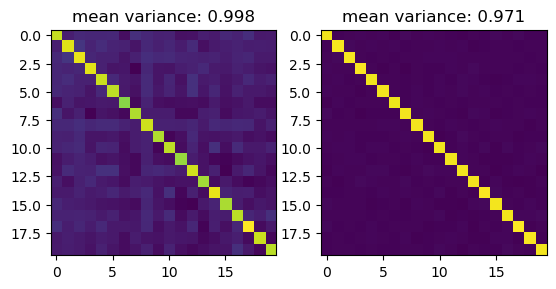

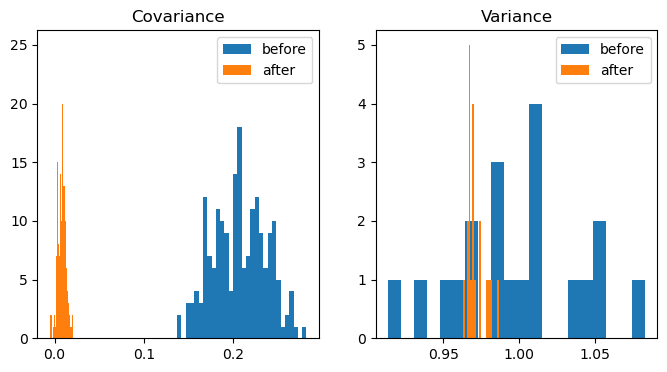

In [2]:
num_samples=1000
num_features=20

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

# create a fully connected decorrelator
model = DecorrelationFC(num_features, whiten=True) # NOTE: the whitening constraint is only realised weakly due to the off-diagonal constraints; we observe a weak tendency to unit variance

# covariance matrix before training
A1 = model.covariance(model.forward(data))

# train decorrelator
for i in range(1000):
    y = model.forward(data)
    model.update()
    model.R -= 1e-3 * model.R.grad
    print(f'iteration {i}; average off-diagonal covariance: {covariance([model])[0].numpy():3f}')

# covariance matrix after training
A2 = model.covariance(model.forward(data))

plt.subplot(1,2,1)
plt.imshow(A1)
plt.title(f'mean variance: {torch.mean(torch.diag(A1)):.3f}')
plt.subplot(1,2,2)
plt.imshow(A2)
plt.title(f'mean variance: {torch.mean(torch.diag(A2)):.3f}');

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(lower_triangular(A1), bins=30)
plt.hist(lower_triangular(A2), bins=30)
plt.title('Covariance')
plt.legend(['before', 'after'])
plt.subplot(1,2,2)
plt.hist(torch.diag(A1), bins=A1.shape[0])
plt.hist(torch.diag(A2), bins=A2.shape[0])
plt.title('Variance')
plt.legend(['before', 'after']);



Decorrelation of correlated input represented in convolutional [N, C, H, W] form

iteration 0; average off-diagonal kernel covariance: 0.713905
iteration 1; average off-diagonal kernel covariance: 0.298486
iteration 2; average off-diagonal kernel covariance: 0.219768
iteration 3; average off-diagonal kernel covariance: 0.177275
iteration 4; average off-diagonal kernel covariance: 0.149968
iteration 5; average off-diagonal kernel covariance: 0.130732
iteration 6; average off-diagonal kernel covariance: 0.116365
iteration 7; average off-diagonal kernel covariance: 0.105189
iteration 8; average off-diagonal kernel covariance: 0.096228
iteration 9; average off-diagonal kernel covariance: 0.088872
iteration 10; average off-diagonal kernel covariance: 0.082719
iteration 11; average off-diagonal kernel covariance: 0.077493
iteration 12; average off-diagonal kernel covariance: 0.072997
iteration 13; average off-diagonal kernel covariance: 0.069086
iteration 14; average off-diagonal kernel covariance: 0.065652
iteration 15; average off-diagonal kernel covariance: 0.062613
it

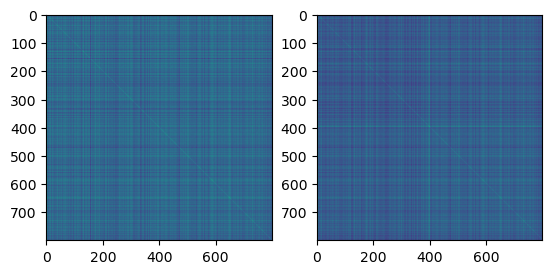

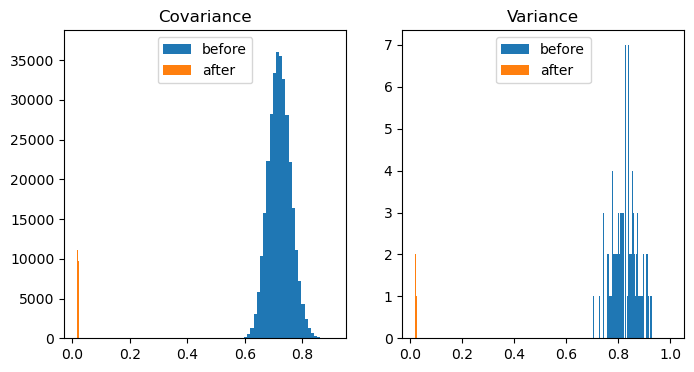

In [3]:
# generate [N, M] correlated input
num_examples=100
num_channels=2
height=20
width=20
num_features=num_channels*height*width
kernel_size=(5,5)

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
data = d.sample((num_examples,)).reshape(num_examples,num_channels,height,width)

# create a convolutional decorrelator
model = DecorrelationPatch2d(2, kernel_size=kernel_size, whiten=True)

# correlation matrix before training
B1 = DecorrelationFC.covariance(model.forward(data).view(num_examples,-1))

# train decorrelator
for i in range(1000):
    y = model.forward(data)
    model.update()
    model.R -= 1e-2 * model.R.grad
    print(f'iteration {i}; average off-diagonal kernel covariance: {covariance([model])[0].numpy():3f}')

# correlation matrix after training
B2 = DecorrelationFC.covariance(model.forward(data).view(num_examples,-1))

plt.subplot(1,2,1)
plt.imshow(B1)
plt.subplot(1,2,2)
plt.imshow(B2)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(lower_triangular(B1), bins=30)
plt.hist(lower_triangular(B2), bins=30)
plt.title('Covariance')
plt.legend(['before', 'after'])
plt.subplot(1,2,2)
plt.hist(torch.diag(B1), bins=B1.shape[0])
plt.hist(torch.diag(B2), bins=B2.shape[0])
plt.title('Variance')
plt.legend(['before', 'after']);

# NOTE: It is likely not the covariance but the correlations we wish to show...

In [4]:
# MAYBE IT ALREADY WORKS? INPUT DATA SHOULD BE TRANSLATION INVARIANT? THIS IS DEFINITELY NOT THE CASE IN GENERAL... NEEDS MORE THOUGHT

To do:
- experiment can be used if current approach works. Do we have any guarantee of decorrelated input if average over patches? and if we take only center pixel? We can check by extracting the patches for the created output again and compute covariances
- reimplement code sander as starting point also for comparison